In [3]:
#!git clone https://github.com/maciejskorski/anticipatio.git

import pandas as pd
from pathlib import Path

def open_fn(f):
    try:
        return pd.read_csv(f,engine='python')
    except:
        return pd.DataFrame()

files = Path('../data/futurists_kol/data').rglob('*csv')
tweets = map(open_fn, files)
tweets = pd.concat(tweets)
tweets.columns = ['index','user','timestamp','url','txt']
tweets.reset_index(drop=True,inplace=True)
print(tweets['user'].nunique(),len(tweets)) # 257 users, 1254244 tweets
tweets['txt'] = tweets['txt'].astype(str)
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

tweets.head()
docs = tweets['txt']

256 1254243


In [4]:
import gc
del tweets
gc.collect()

100

# Online Model

In [6]:
import numpy as np
#np.save('embeds',embeds)
embeds = np.load('embeds.npy')

In [7]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from bertopic.vectorizers import OnlineCountVectorizer

# Prepare sub-models that support online learning
umap_model = IncrementalPCA(n_components=10)
cluster_model = MiniBatchKMeans(n_clusters=200, random_state=0)
vectorizer_model = OnlineCountVectorizer(stop_words="english", decay=.01)

2023-06-10 15:43:08.930342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 15:43:15.967854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 15:43:15.969690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-

In [13]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = "true"
from bertopic import BERTopic

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=cluster_model,
    vectorizer_model=vectorizer_model,
    low_memory=True,
    verbose=True,
    min_topic_size=100, 
    nr_topics="auto", 
)

In [14]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    
    def __init__(self, docs, embeds):
        self.docs = docs
        self.embeds = embeds
        
    def __getitem__(self, index):
        return (self.docs[index],self.embeds[index])
    
    def __len__(self):
        return len(self.docs)

In [15]:
topics = []
for docs_batch, embeds_batch in DataLoader(MyDataset(docs,embeds),batch_size=100000, shuffle=True):
    print('doing batch')
    topic_model.partial_fit(docs_batch, embeds_batch.numpy())
    topics.extend(topic_model.topics_)
    #topic_model.fit(docs_batch)
#    pass

topic_model.topics_ = topics

doing batch


2023-06-10 15:59:56,675 - BERTopic - Reduced dimensionality
2023-06-10 15:59:57,061 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:00:13,684 - BERTopic - Reduced dimensionality
2023-06-10 16:00:14,016 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:00:28,122 - BERTopic - Reduced dimensionality
2023-06-10 16:00:28,496 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:00:42,631 - BERTopic - Reduced dimensionality
2023-06-10 16:00:43,004 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:00:58,512 - BERTopic - Reduced dimensionality
2023-06-10 16:00:58,851 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:01:13,805 - BERTopic - Reduced dimensionality
2023-06-10 16:01:14,162 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:01:27,547 - BERTopic - Reduced dimensionality
2023-06-10 16:01:27,891 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:01:42,407 - BERTopic - Reduced dimensionality
2023-06-10 16:01:42,750 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:01:58,735 - BERTopic - Reduced dimensionality
2023-06-10 16:01:59,107 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:02:12,841 - BERTopic - Reduced dimensionality
2023-06-10 16:02:13,223 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:02:27,173 - BERTopic - Reduced dimensionality
2023-06-10 16:02:27,549 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:02:42,637 - BERTopic - Reduced dimensionality
2023-06-10 16:02:42,987 - BERTopic - Clustered reduced embeddings


doing batch


2023-06-10 16:02:54,396 - BERTopic - Reduced dimensionality
2023-06-10 16:02:54,750 - BERTopic - Clustered reduced embeddings


# Visualization

In [16]:
topic_model.visualize_hierarchy()

In [25]:
from itables import init_notebook_mode, show
#init_notebook_mode(all_interactive=True)

topic_info = topic_model.get_topic_info()
show(topic_info)

# Validation

In [19]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
docs_tokenized = [analyzer(doc) for doc in docs]
docs_tokenized = [d for d in docs_tokenized if len(d)>0]
dictionary = corpora.Dictionary(docs_tokenized)
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(1,len(topic_model.topic_sizes_)-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=docs_tokenized,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print('coherence=',coherence)

coherence= 0.6198733314829051


In [30]:
print('coherence=',coherence)

coherence= 0.5625459611857069


# Old

In [4]:
from bertopic import BERTopic
import cuml
import umap
from sklearn import decomposition

umap_model = cuml.UMAP(n_components=5, n_neighbors=5, min_dist=0.0, metric='euclidean', n_epochs=1000)
umap_model = decomposition.PCA(n_components=10)
hdbscan_model = cuml.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True, prediction_data=True)

2023-06-10 14:54:46.289291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 14:54:53.264526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 14:54:53.267158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-

In [82]:
#umap_model = umap_model.fit(embeds[:100000])
#umap_embeds = umap_model.transform(embeds[:100000])

embdes_simpler = decomposition.PCA(100).fit_transform(embeds[:200000])

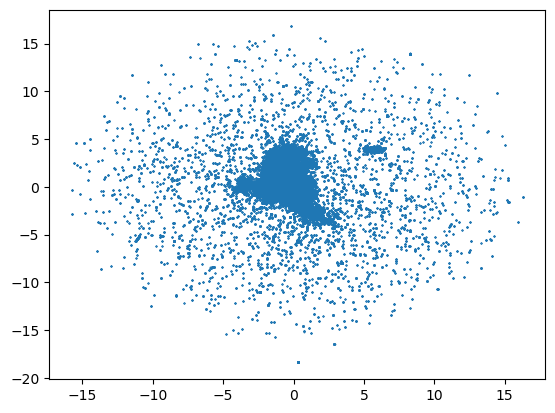

In [89]:
import matplotlib.pyplot as plt

umap_embeds = umap_model.fit_transform(embeds[:200000])
plt.scatter(umap_embeds[:,0], umap_embeds[:,1], s=0.1, cmap='Spectral')
plt.show()

In [ ]:
f = umap.plot.interactive(embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
show(f)

In [58]:
#topic_model.umap_model.__dict__

In [92]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = "true"
from bertopic import BERTopic

topic_model = BERTopic(
    min_topic_size=100, 
    #umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics="auto", 
    low_memory=True, 
    calculate_probabilities=False, 
    verbose=True
)

topic_model.fit(docs[:200000], embeds[:200000])#embeds[:200000])

2023-06-10 13:06:13,191 - BERTopic - Reduced dimensionality
2023-06-10 13:06:47,924 - BERTopic - Clustered reduced embeddings
2023-06-10 13:07:08,483 - BERTopic - Reduced number of topics from 14 to 14


In [16]:
len(topic_model.topic_sizes_)
#sentence_model.embed_documents

120